### Machine learning model to predict property prices in Colombia

Import all modules we'll be using

In [1]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pygeos
import geopy
import numpy as np
import missingno as msno
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy as sp


d:\Python\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (None)/charset_normalizer (3.0.0) doesn't match a supported version!
  warnings.warn(


First open both csv train and test in their respective dataframe

In [2]:
traindf = pd.read_csv("..\properties_colombia_train.csv")
testdf = pd.read_csv("..\properties_colombia_test.csv")

Delete rows with wrong coordinates where points away from colombia or doesn't have coordinates (the number of wrong coordinates is 49.490 rows), this is important because the algorithm used to predict uses coordinates among other variables to predict. If i try to imput the missing cordinates it could  add bias to the algorithm.

also I take the oportunity to graficate the coordinates in a map

d:\Python\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


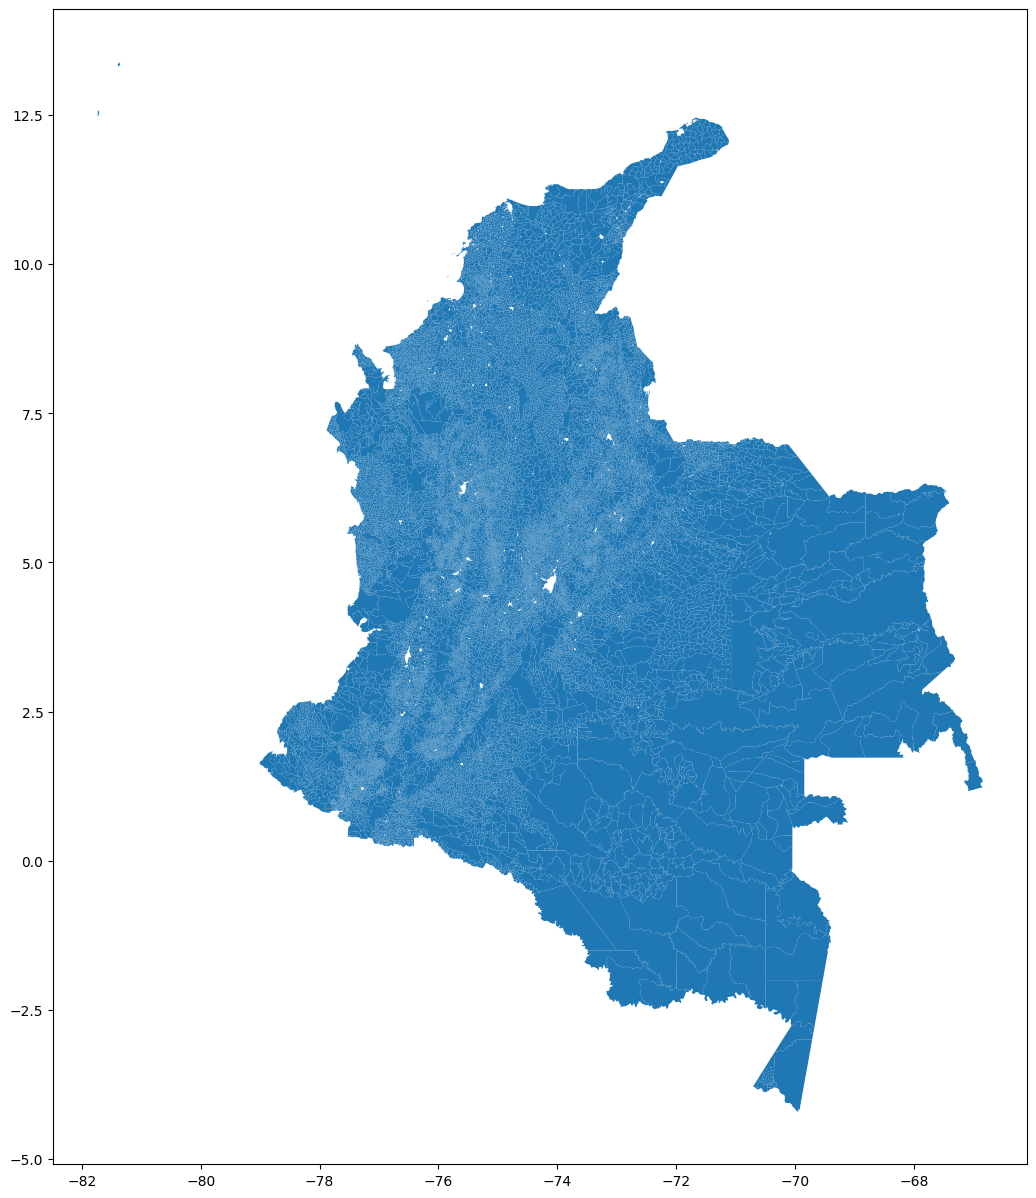

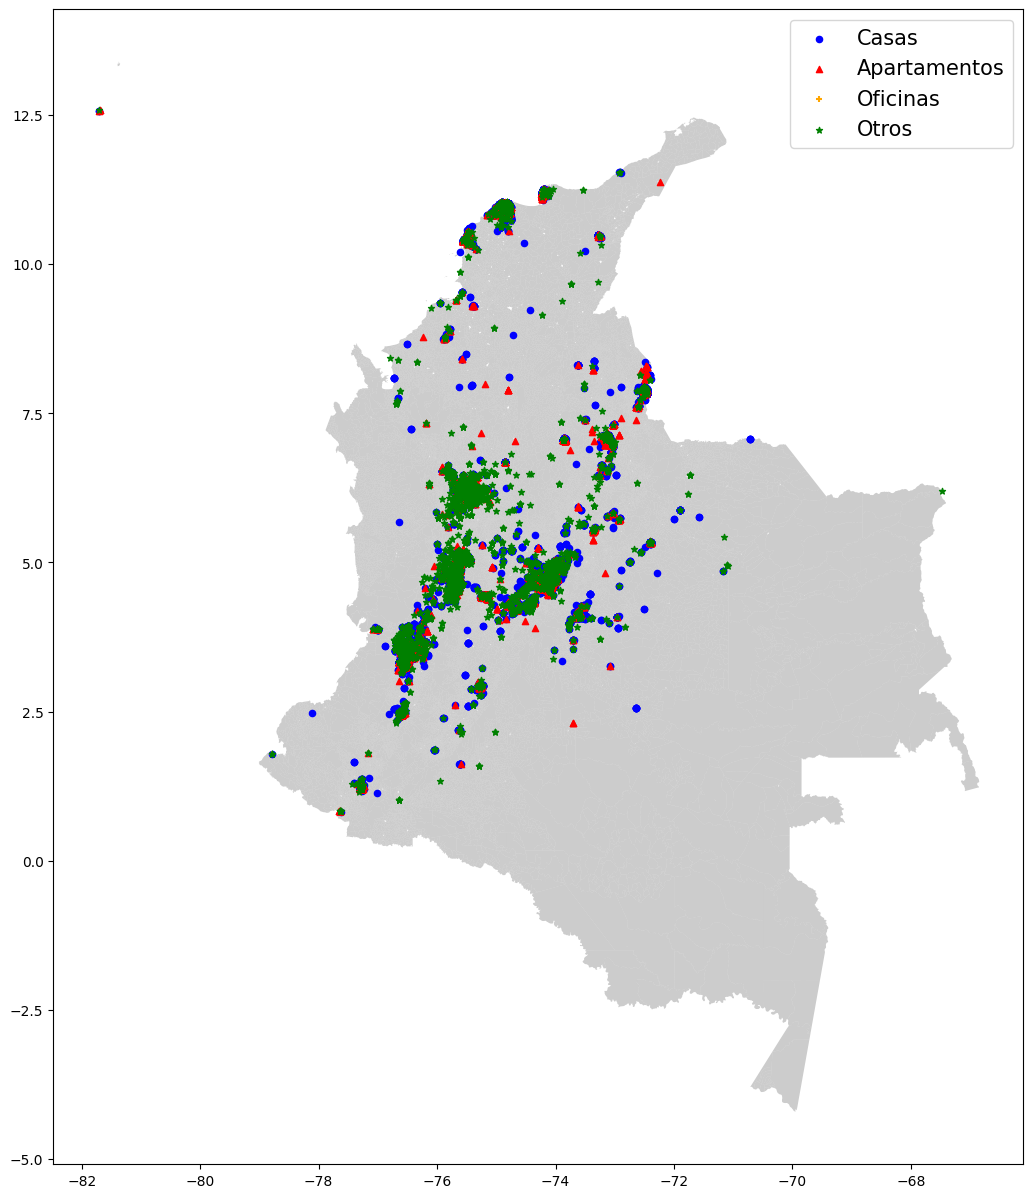

In [3]:
crs ={"init": "epsg:4326"}
traindf = traindf.query('-82 < lon < -66')
traindf = traindf.query('-5 < lat < 15')
colombia_map = gpd.read_file("ShapeFile\CRVeredas_2020.shp")
fig,ax = plt.subplots(figsize= (15,15))
colombia_map.plot (ax = ax)
geometry = gpd.points_from_xy(traindf["lon"], traindf["lat"])
gdf = gpd.GeoDataFrame(traindf, crs=crs, geometry=geometry)
fig,ax = plt.subplots(figsize= (15,15))
colombia_map.plot(ax = ax, alpha = 0.4, color="grey")
gdf[gdf["property_type"]=="Casa"].plot(ax=ax, markersize=20, color="blue", marker="o", label = "Casas")
gdf[gdf["property_type"]=="Apartamento"].plot(ax=ax, markersize=20, color="red", marker="^", label = "Apartamentos")
gdf[gdf["property_type"]=="Oficina"].plot(ax=ax, markersize=20, color="orange", marker="+", label = "Oficinas")
gdf[gdf["property_type"]=="Otro"].plot(ax=ax, markersize=20, color="Green", marker="*", label = "Otros")
plt.legend(prop={"size":15})

Then I create the new column "Target"  using 0 for prices below and 1 for prices above the median

all this before any other deletion or transformation of the data.

In [4]:
conditions = [
    traindf["price"] >= traindf["price"].median(axis=0, skipna=True),
    traindf["price"] < traindf["price"].median(axis=0, skipna=True)
]

outputs = [1, 0]
           
        
res = np.select(conditions, outputs)
pd.Series(res)

traindf["Target"] = res


Using missingno graficate all  variables to find which one have missing data

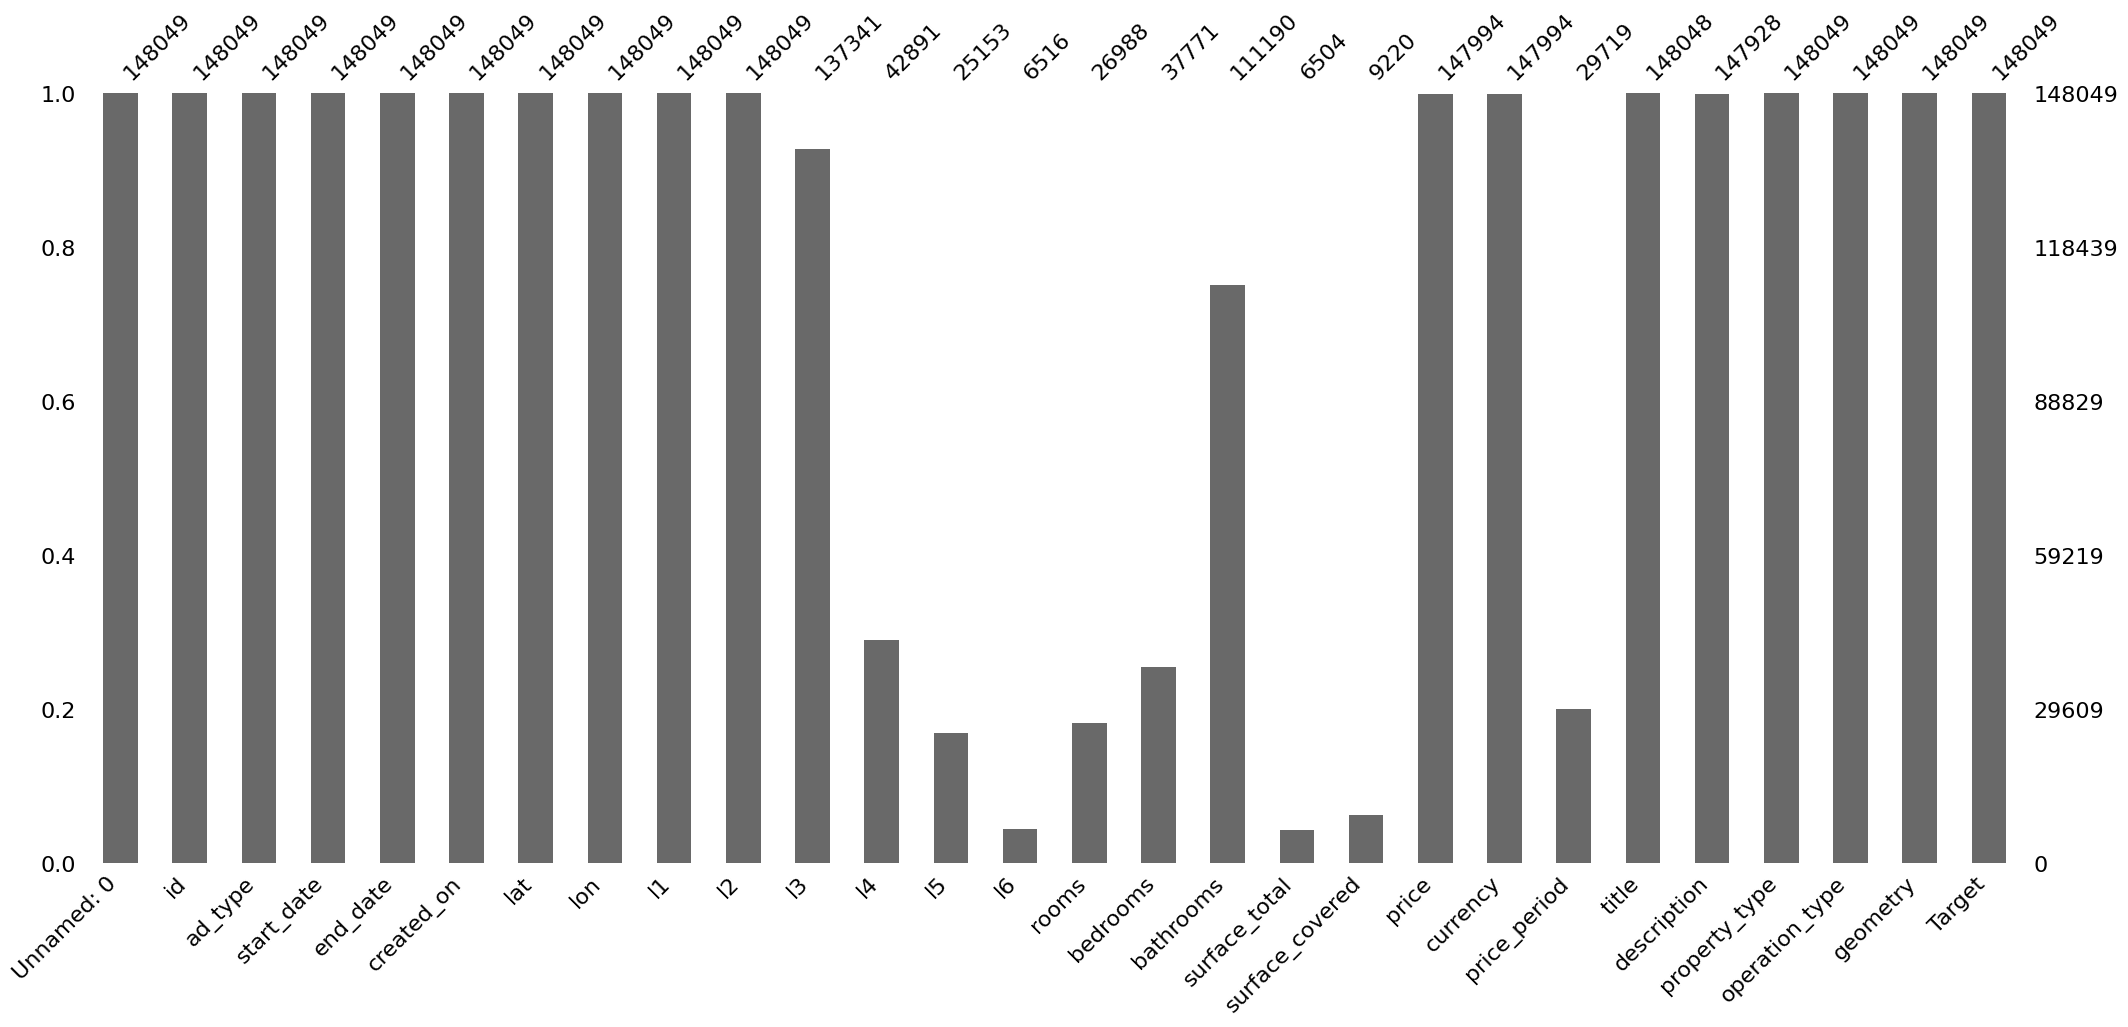

In [5]:
msno.bar(traindf)
plt.show()

To have better understanding on the missing data I print the percentage missing only on the columns i identificate have that less data

In [6]:
print('Porcentaje de valores faltantes de la variable l3:', (traindf.l3.isnull().sum()/len(traindf)) * 100)
print('Porcentaje de valores faltantes de la variable l4:', (traindf.l4.isnull().sum()/len(traindf)) * 100)
print('Porcentaje de valores faltantes de la variable l5:', (traindf.l5.isnull().sum()/len(traindf)) * 100)
print('Porcentaje de valores faltantes de la variable l6:', (traindf.l6.isnull().sum()/len(traindf)) * 100)
print('Porcentaje de valores faltantes de la variable rooms:', (traindf.rooms.isnull().sum()/len(traindf)) * 100)
print('Porcentaje de valores faltantes de la variable bedrooms:', (traindf.bedrooms.isnull().sum()/len(traindf)) * 100)
print('Porcentaje de valores faltantes de la variable surface_total:', (traindf.surface_total.isnull().sum()/len(traindf)) * 100)
print('Porcentaje de valores faltantes de la variable surface_covered:', (traindf.surface_covered.isnull().sum()/len(traindf)) * 100)

Porcentaje de valores faltantes de la variable l3: 7.232740511587379
Porcentaje de valores faltantes de la variable l4: 71.02918628291984
Porcentaje de valores faltantes de la variable l5: 83.01035467986951
Porcentaje de valores faltantes de la variable l6: 95.59875446642666
Porcentaje de valores faltantes de la variable rooms: 81.77090017494208
Porcentaje de valores faltantes de la variable bedrooms: 74.48750075988355
Porcentaje de valores faltantes de la variable surface_total: 95.60685989098204
Porcentaje de valores faltantes de la variable surface_covered: 93.7723321332802


As you se above  l4, l5, l6, rooms, bedrooms, surface_total and surface_covered   have over 70% of missing data; the last 4 mentioned can't be imputed using any statistical ratio because that depends on many other factors like "estrato" (couldn't find a translation to that word that categorices houses depending on economical and social variables), so  nor the price, nor the property_type really relates with the other columns

also l3, l4, l5 and l6 coul'd be imputed using the geocordinates but it won't be necessary due that I will be using the coordinates to spatially place the property.

nonetheless under this MD is an example on how we could impute l3 using geocordinates that it won't be necessary to run; I didn't chose this route because  retrieving the data of the coordinates and inserting it to the dataframes consume a lot of power and time (around 10 minutes executing the code)

In [7]:

#def test(x):
#    geolocator = Nominatim(user_agent="coordinateconverter")
#    address = x["lat"], x["lon"]
#    try:
#        location = geolocator.reverse(address)
#        x["l4"] = location.raw["address"]["suburb"]
#        print(location.raw["address"]["city"], location.raw["address"]["suburb"])
#        return x
#    except:
#        pass
#    
#    
#traindf.apply(test,axis=1)


Delete the currency filled with None or USD, these are something like 50 rows that doesn't represent much. I coul'd transform USD to COP but it's to much work for too few data

In [8]:
traindf = traindf[traindf["currency"]!= "USD"]
traindf = traindf[traindf["currency"].notna()]

impute the missing data of bathrooms using de median, it's not worth to delete this rows because they conform 20% of data

In [9]:
traindf["bathrooms"].fillna(traindf["bathrooms"].notna().median(), inplace=True)

Some code to delete outliers i don't use in the regression because the test.csv was extracted randomly from the train.csv, so it would be supposed that have the same outliers composition; either way the scrypt is below

In [10]:
#Q1 = traindf["price"].quantile(0.25)
#Q3 = traindf["price"].quantile(0.75)
#IQR = Q3 - Q1
#BI = Q1 - 1.5*IQR
#BS = Q3 + 1.5*IQR
#
#print(Q1)
#print(Q3)
#print(IQR)
#print(BI)
#print(BS)
#
#print('Cantidad de registros totales:', traindf.shape[0])
#print('Cantidad de outliers:', traindf[(traindf['price']<BI) | (traindf['price']>BS)].shape[0] )
#
#out_price = (traindf['price']<BI) | (traindf['price']>BS) 
#
#traindf = traindf[~out_price]


histplot, boxplot and heatmap to analize the data; It doesn't show much because outliers degrade the visual comprehension

In [11]:
#sns.histplot(x = "price", data= traindf, kde = True)
#plt.show()

In [12]:
#sns.boxplot(x = "price", data = traindf)
#plt.show()

In [13]:
#sns.heatmap(traindf.corr())
#plt.show

Slice the dataframe leaving only the columns i'll be using, this is not necessary but to simplify understanding

In [14]:
traindf = traindf.drop(
    [
        "Unnamed: 0",
        "id",
        "ad_type",
        "start_date",
        "end_date",
        "l1",
        "l2",
        "l3",
        "l4",
        "l5",
        "l6",
        "surface_total",
        "surface_covered",
        "price_period",
        "operation_type",
        "title",
        "description",
        "currency",
        "created_on",
        "price",
        "rooms",
        "bedrooms",
    ],
    axis=1,
)

Confirm that the data don't have any more missing values

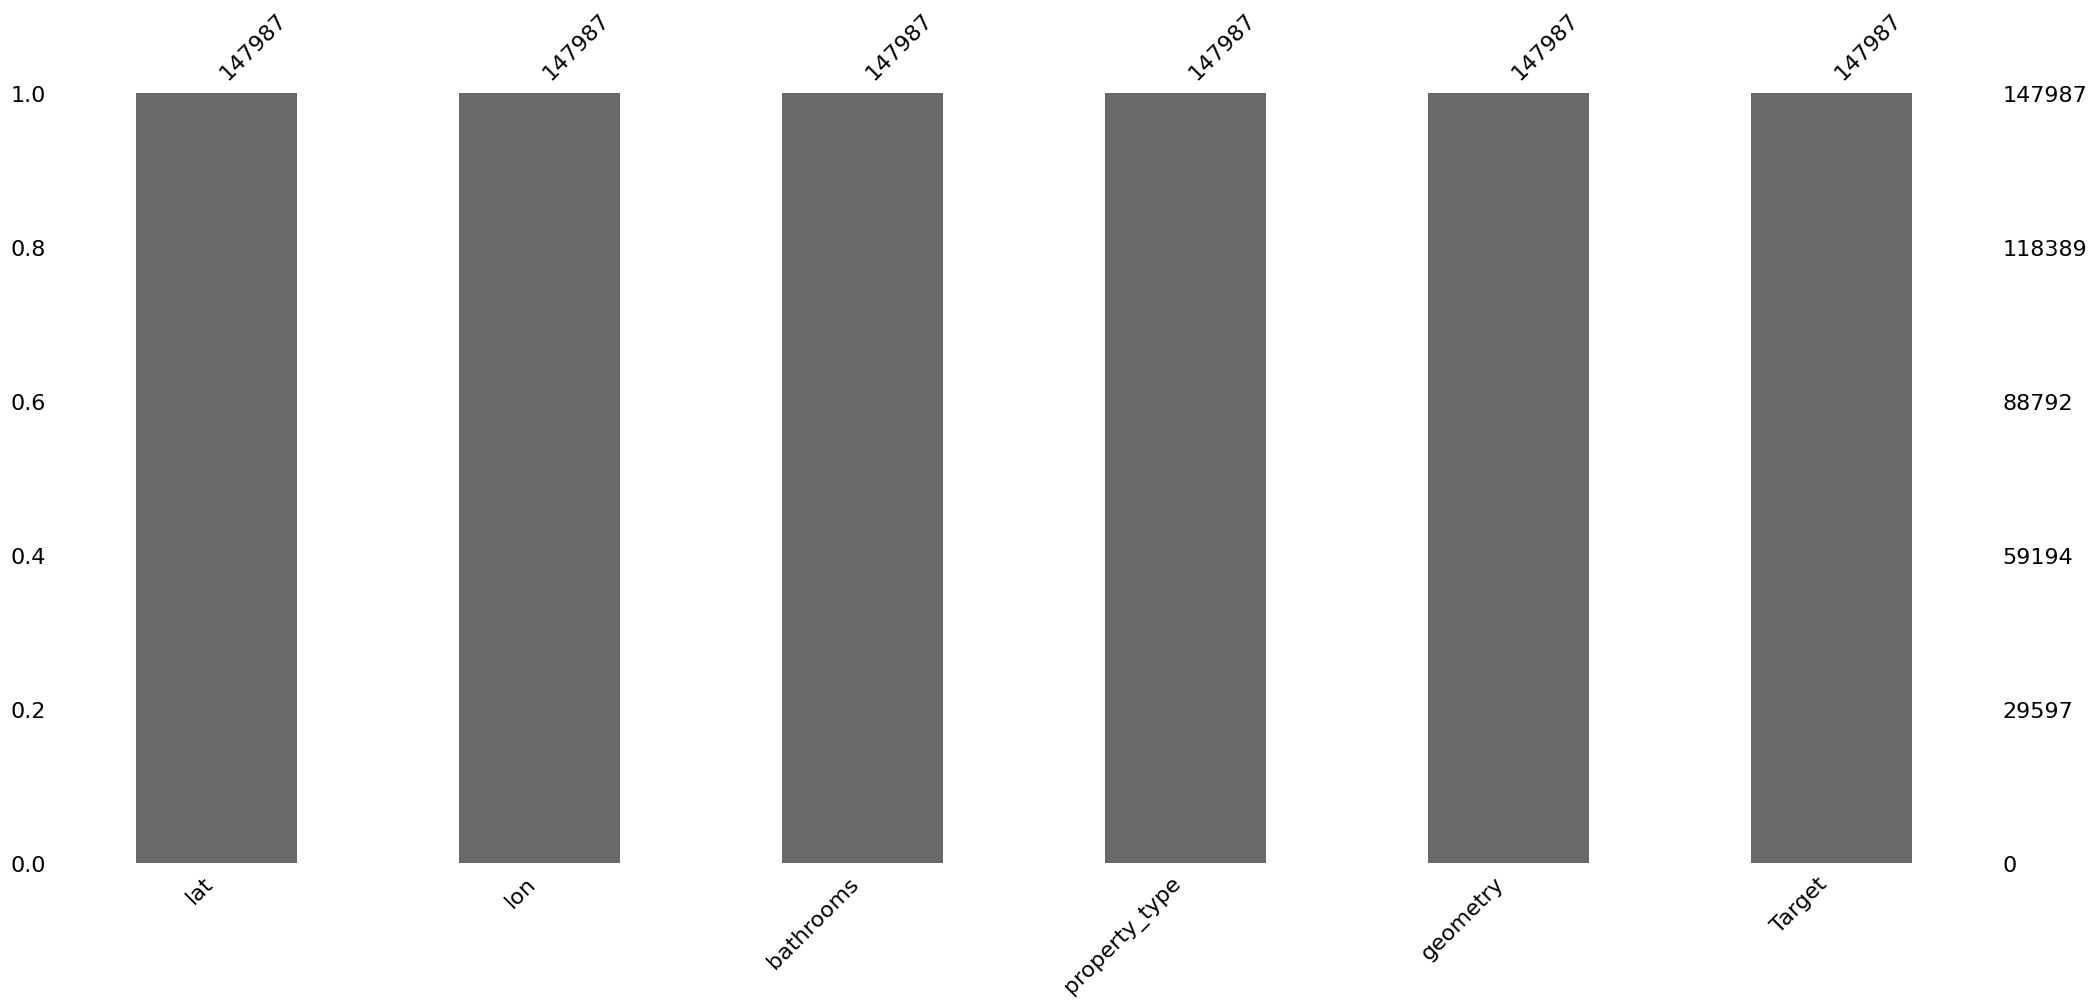

In [15]:
msno.bar(traindf)
plt.show()

Encode non numeric variables 

In [16]:
label_encoder = preprocessing.LabelEncoder() 
traindf['property_type'] = label_encoder.fit_transform(traindf['property_type'])

### KNN Algorithm

create an instance of KNeighborsClassifier, define hyperparameters such as test size and number of neighbor
I define the number of neighbors empirically trying multiple impair values after I find the better one where the accuracy is higher with a lower log loss... in this case I find it is 9

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, y_train)

Define which values will be used to  predict, also what's the target to be predicted

In [18]:
X = traindf[['lat', 'lon', "bathrooms", "property_type"]]                                                   
y = traindf.Target 

fit the values to the algorithm

In [20]:
clf.fit(X.values,y.values)

KNeighborsClassifier()

Train the algorithm

In [21]:
y_pred = clf.predict(X.values)

look up the accuracy, precision and recall of the algorithm, the closer to 1 the better to predict correctly the target value

In [22]:

print("accuracy:", accuracy_score(y,y_pred))

print("precision:", precision_score(y, y_pred, average='macro'))

print("recall:", recall_score(y, y_pred, average='macro'))

accuracy: 0.9040388682789704
precision: 0.9040400132577968
recall: 0.9040393265050656


Calculate the log loss as other variable to evaluate the performance of the trained algorithm

It is a measure of uncertainty (you may call it entropy), so a low Log Loss means a low uncertainty/entropy of your model. Log Loss is similar to the Accuracy, but it will favor models that distinguish more strongly the classes. Log Loss it useful to compare models not only on their output but on their probabilistic outcome.


In [23]:
PredProb=clf.predict_proba(X_test)
pred=np.asmatrix(PredProb)
pred.columns=('high','low','medium')
s=np.asmatrix(pd.get_dummies(y_test))
def f(x):
    return sp.log(sp.maximum(sp.minimum(x,1-10**-5),10**-5))
f=np.vectorize(f)
predf=f(pred)
mult=np.multiply(predf,s)
print('log loss =',np.sum(mult)/-len(y_test))

C:\Users\salas\AppData\Local\Temp\ipykernel_19624\3272479765.py:6: DeprecationWarning: scipy.minimum is deprecated and will be removed in SciPy 2.0.0, use numpy.minimum instead
  return sp.log(sp.maximum(sp.minimum(x,1-10**-5),10**-5))
C:\Users\salas\AppData\Local\Temp\ipykernel_19624\3272479765.py:6: DeprecationWarning: scipy.maximum is deprecated and will be removed in SciPy 2.0.0, use numpy.maximum instead
  return sp.log(sp.maximum(sp.minimum(x,1-10**-5),10**-5))
C:\Users\salas\AppData\Local\Temp\ipykernel_19624\3272479765.py:6: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  return sp.log(sp.maximum(sp.minimum(x,1-10**-5),10**-5))


log loss = 0.4584258201729797


Now to Apply the algorithm to the test dataframe I need to normalize it normalize it with respect to training one

Given that this is the test I can't delete any rows, so in this case i'll use the departament and city to impute the new coordenates 

In [24]:
medians = testdf.groupby(["l2", "l3"])["lat"].transform('median')
testdf["lat"] = testdf["lat"].fillna(medians)

In [25]:
medians = testdf.groupby(["l2", "l3"])["lon"].transform('median')
testdf["lon"] = testdf["lon"].fillna(medians)

In [26]:
medians = testdf.groupby(["l2"])["lat"].transform('median')
testdf["lat"] = testdf["lat"].fillna(medians)

medians = testdf.groupby(["l2"])["lon"].transform('median')
testdf["lon"] = testdf["lon"].fillna(medians)

Also impute a median of bathrooms

In [27]:
mediansbath = testdf["bathrooms"].notna().median()
testdf["bathrooms"] = testdf["bathrooms"].fillna(mediansbath)

Confirm that the all coordinates are in colombia

d:\Python\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


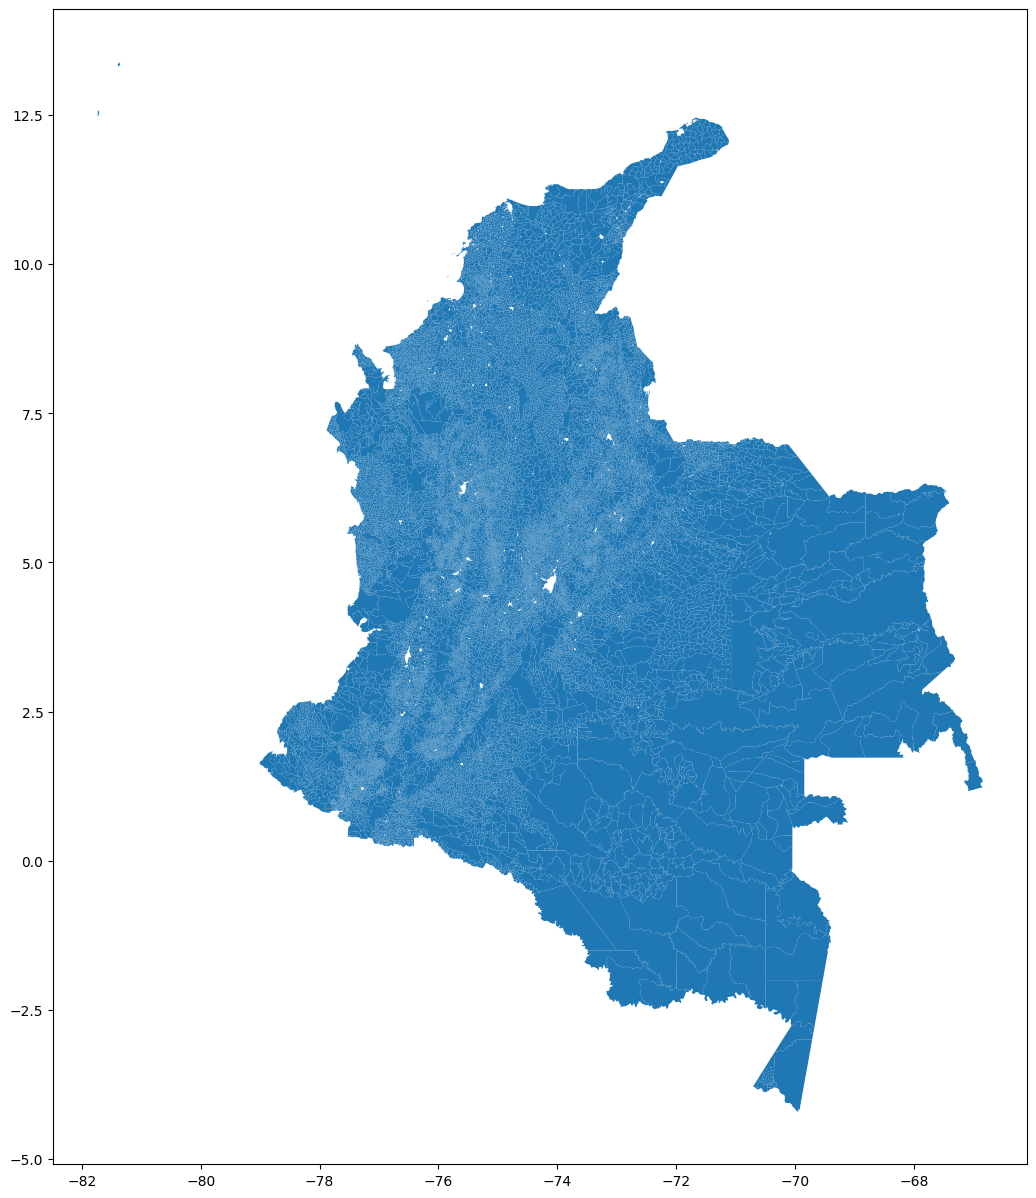

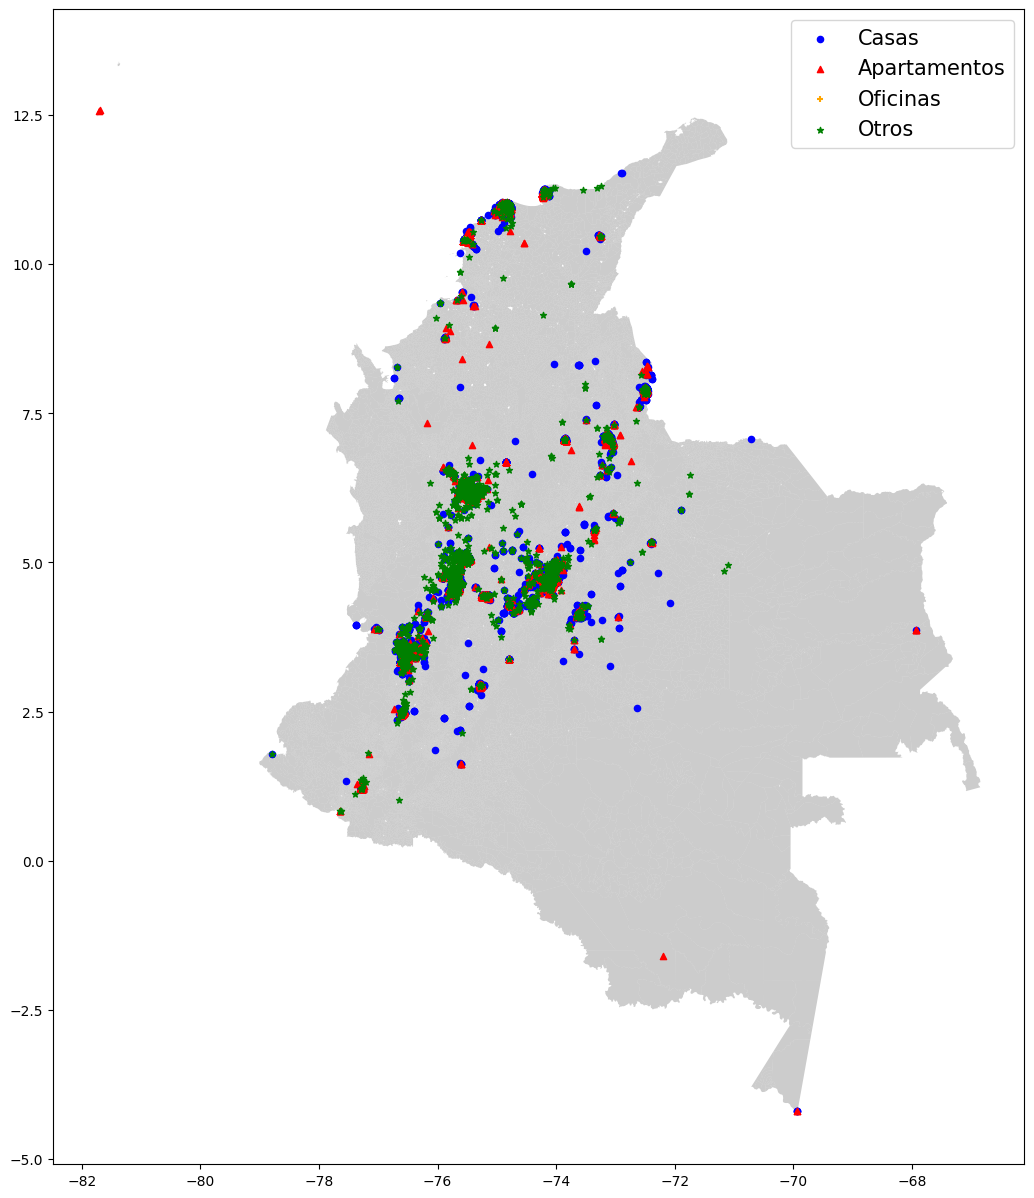

In [28]:
crs ={"init": "epsg:4326"}
#traindf = traindf.query('-82 < lon < -66')
#traindf = traindf.query('-5 < lat < 15')
colombia_map = gpd.read_file("ShapeFile\CRVeredas_2020.shp")
fig,ax = plt.subplots(figsize= (15,15))
colombia_map.plot (ax = ax)
geometry = gpd.points_from_xy(testdf["lon"], testdf["lat"])
gdf = gpd.GeoDataFrame(testdf, crs=crs, geometry=geometry)
fig,ax = plt.subplots(figsize= (15,15))
colombia_map.plot(ax = ax, alpha = 0.4, color="grey")
gdf[gdf["property_type"]=="Casa"].plot(ax=ax, markersize=20, color="blue", marker="o", label = "Casas")
gdf[gdf["property_type"]=="Apartamento"].plot(ax=ax, markersize=20, color="red", marker="^", label = "Apartamentos")
gdf[gdf["property_type"]=="Oficina"].plot(ax=ax, markersize=20, color="orange", marker="+", label = "Oficinas")
gdf[gdf["property_type"]=="Otro"].plot(ax=ax, markersize=20, color="Green", marker="*", label = "Otros")
plt.legend(prop={"size":15})

Delete unnecesary columns

In [29]:
testdf = testdf.drop(
    [
        "Unnamed: 0",
        "id",
        "ad_type",
        "start_date",
        "end_date",
        "l1",
        "l2",
        "l3",
        "l4",
        "l5",
        "l6",
        "surface_total",
        "surface_covered",
        "price_period",
        "operation_type",
        "title",
        "description",
        "currency",
        "created_on",
        "rooms",
        "bedrooms",
    ],
    axis=1,
)

encode non numeric variables

In [30]:
label_encoder = preprocessing.LabelEncoder() 
testdf['property_type'] = label_encoder.fit_transform(testdf['property_type'])

Apply trained algorithm to predict 

In [31]:
X = testdf[['lat', 'lon', "bathrooms", "property_type"]]
y_pred = clf.predict(X.values)

Save the results in a .csv

In [32]:
results = pd.DataFrame({'pred': y_pred})

In [33]:
results.to_csv("Emblask39.csv", index=False)